<a href="https://colab.research.google.com/github/morganmcg1/reformer-fastai/blob/main/experiments/LM_exp_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import sys
# if 'google.colab' in sys.modules:
#     !pip install -Uqq fastai einops datasets
!pip install git+https://github.com/butchland/my_timesaver_utils/

  Cloning https://github.com/butchland/my_timesaver_utils/ to /tmp/pip-req-build-a4e0dvcm
  Created wheel for my-timesaver-utils: filename=my_timesaver_utils-0.0.2-py3-none-any.whl size=21461 sha256=a985e98730b6884b4d1566996319e714a2e2589e9a01ceb99ca32806c0d6bfaa
  Stored in directory: /tmp/pip-ephem-wheel-cache-ar43m79z/wheels/9e/67/8f/783856e273ff940f438565389bfd500a016ba8748448ab7225
Successfully built my-timesaver-utils


In [2]:
import sys
import six
from fastai.text.all import *

/home/tyoc213/Documents/github/fastai/fastai/callback/hook.py:190: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if np is not '':


In [3]:
sys.path.append("..")
from basic_tokenizers import ByteTextTokenizer
from basic_transformer import TransformerLM
from make_dataset import read_and_prepare_data
from my_timesaver_utils.all import MyProfileCallback

No module named 'axial_positional_embedding'


## Experiment Tracking

Make sure you have wandb and are logged in:

In [4]:
# !pip install -Uqq wandb
# !wandb login

Load Experiment Tracking with Weights & Biases:

## Wandb experiment logging
Suggeted [wandb.init logging](https://docs.wandb.com/library/init) to help keep track of experiments:

**WANDB_NAME**

A specific name for a particular experiment, e.g. "lsh_2_hash_enwik8"

**GROUP**

Group identifiers will help organise and **group experiments together** in the wandb interface. Suggested identifier to use are:

- "TEST" : for general testing
- "SHARED-QK" : for Shared Query-Key experiments
- "LSH" : LSH-related experiemnts
- "REVERSIBLE" : reversible layers experiments
- "WMT" : for the WMT task

**NOTES**

A longer description of the run, like a -m commit message in git. This helps you remember what you were doing when you ran this run.

**CONFIG**

A dictionary-like object for saving inputs to your job, like hyperparameters for a model or settings for a data preprocessing job. The config will show up in a table in the UI that you can use to group, filter, and sort runs. Keys should not have . in the names, and values should be under 10 MB.

**TAGS**

A list of strings, which will populate the list of tags on this run in the UI. Tags are useful for organizing runs together, or applying temporary labels like "baseline" or "production". It's easy to add and remove tags in the UI, or filter down to just runs with a specific tag.

In [5]:
import wandb
from fastai.callback.wandb import *

WANDB_NAME = 'enc_lm_enwik8'
GROUP = 'TEST'     # Group to add a run to, e.g. "LSH" for LSH experiments, "REVERSIBLE" for reversible layers
NOTES = 'Testing the encoder LM model works'
CONFIG = {}
TAGS =['enc_lm','test']

Initialise wandb logging, pleaes **do not change** `project` or `entity` (that that everything gets logged to the same place)

In [6]:
# wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
#            name=WANDB_NAME, group=GROUP, notes=NOTES,  tags=TAGS) # config=CONFIG,

## Download and Unpack enwik8 Data

Download and unzip enwik8 data

In [7]:
#!wget -P data/ http://mattmahoney.net/dc/enwik8.zip
#!unzip data/enwik8.zip -d data/
#!ls data
#!head -n 132 data/enwik8

# Prepare Data

In [8]:
# df has columns [text, lens, lens_cum_sum], add a numerical seq_length argument
# to the function below if you'd like to split the data into samples with that seq length
df = read_and_prepare_data('data/enwik8')

Reading data from path...
Done!


Load tokenizer

In [9]:
bte = ByteTextTokenizer(is_lm=True, add_bos=True, add_eos=True)

In [10]:
## TINY DF FOR TESTING
df = df.iloc[:400].copy()
train_cutoff = int(df.lens.sum()*0.5)

Get train cutoff, split enwik8 by character count

In [11]:
# df['lens'] = df['text'].str.len()
# df['lens_cum_sum'] = df.lens.cumsum()
# train_cutoff = df.lens.sum() - 10000000  # keep all but 10M characters for val and test

Calc splits

In [12]:
train_idxs = df.loc[df['lens_cum_sum'] < train_cutoff].index.values
train_idxs = list(range(0, max(train_idxs)))

remaining_idxs = len(df) - max(train_idxs)
validation_idxs = list(range(max(train_idxs), max(train_idxs) + int(remaining_idxs/2)))
test_idxs = list(range(max(validation_idxs), len(df)))

splits = [train_idxs, validation_idxs]

Get dls

In [13]:
# Quick naive split alternative
# cut = int(len(df)*0.8)
# splits = range_of(df)[:cut], range_of(df[cut:])

tfms = [attrgetter("text"), bte]
dsets = Datasets(df, [tfms, tfms], splits=splits, dl_type=LMDataLoader)

vocab_sz = bte.vocab_size
bs,sl = 32,128
pad_seq2seq = partial(pad_input, pad_idx=bte.pad_token_id, pad_fields=[0,1])

dls = dsets.dataloaders(bs=bs, seq_len=sl, before_batch=pad_seq2seq)
dls.show_batch(max_n=2)

,text,text_
0,<bos> <revision>\n<eos><bos> <case>first-letter</case>\n<eos><bos>The word '''anarchism''' is [[etymology|derived from]] the [[Greek language|Gr,<revision>\n<eos><bos> <case>first-letter</case>\n<eos><bos>The word '''anarchism''' is [[etymology|derived from]] the [[Greek language|Gre
1,"thoritarian]] society. In place of what are regarded as authoritarian political structures and coercive economic institutions, a","horitarian]] society. In place of what are regarded as authoritarian political structures and coercive economic institutions, an"


In [14]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

((32, 128), (32, 128))

In [15]:
vocab_sz = bte.vocab_size

# Begin Experiment Training

In [16]:
wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES,  tags=TAGS) # config=CONFIG,

wandb: Currently logged in as: fastai_community (use `wandb login --relogin` to force relogin)


In [17]:
learn = Learner(dls, TransformerLM(vocab_sz, 512),
                loss_func=CrossEntropyLossFlat(), cbs=[WandbCallback(log_model=False, log_preds=False)],
                metrics=[accuracy, Perplexity()]).to_native_fp16()

SuggestedLRs(lr_min=0.03630780577659607, lr_steep=0.3019951581954956)

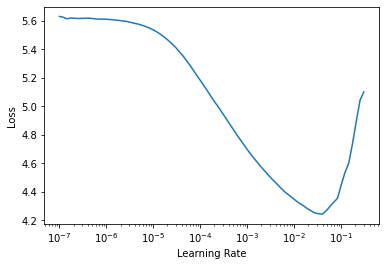

In [18]:
learn.lr_find()

In [19]:
learn.to_my_profile()
learn.fit_one_cycle(2, 5e-4, wd=0.05)  # cbs=WandbCallback(log_model=False)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.498449,3.559684,0.127125,35.152088,00:01
1,4.030394,3.425309,0.127125,30.732138,00:01


In [20]:
learn.my_profile.print_stats()

fit  called 1 times. max: 3.115 avg: 3.115
   epoch  called 2 times. max: 1.522 avg: 1.512
      train  called 2 times. max: 1.148 avg: 1.145
         train_batch  called 16 times. max: 0.082 avg: 0.074
            train_pred  called 16 times. max: 0.016 avg: 0.013
            train_loss  called 16 times. max: 0.001 avg: 0.001
            train_backward  called 16 times. max: 0.040 avg: 0.035
            train_step  called 16 times. max: 0.026 avg: 0.020
            train_zero_grad  called 16 times. max: 0.005 avg: 0.004
      valid  called 2 times. max: 0.372 avg: 0.358
         valid_batch  called 10 times. max: 0.024 avg: 0.019
            valid_pred  called 10 times. max: 0.014 avg: 0.011
            valid_loss  called 10 times. max: 0.001 avg: 0.001


In [21]:
learn.my_profile.clear_stats()